# Load Dependencies

In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
import shutil

In [2]:
make_id = 1
model_id = 1101
released_year = 2011
image_name = '07b90decb92ba6.jpg'

# compcars

In [3]:
DATA_DIR = os.path.join('.', 'data','CompCars','data')

## load image and bounding box

In [38]:
image_path = os.path.join(DATA_DIR, 'image',str(make_id), str(model_id), str(released_year), image_name)
label_path = os.path.join(DATA_DIR, 'label', str(make_id), str(model_id), str(released_year), image_name.replace('.jpg', '.txt'))
image = cv2.imread(image_path)

In [39]:
with open(label_path, 'r') as f:
    lines = f.readlines()

In [40]:
bbox = lines[2].strip('\n')

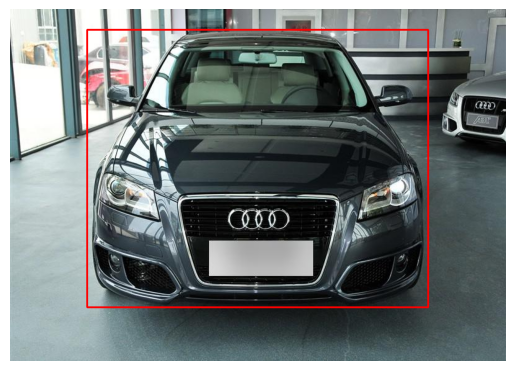

In [ ]:
# ...existing code...

# Convert BGR to RGB
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display using matplotlib
# plt.imshow(img_rgb)
# plt.axis('off')  # Hide axes
# plt.show()

# Parse bbox string to integers
# Assuming bbox format: "xmin ymin xmax ymax"
xmin, ymin, xmax, ymax = map(int, bbox.split())

# Draw rectangle on a copy of the image
img_with_bbox = img_rgb.copy()
cv2.rectangle(img_with_bbox, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2)

# Display the image with bbox
plt.imshow(img_with_bbox)
plt.axis('off')
plt.show()

# ...existing code...

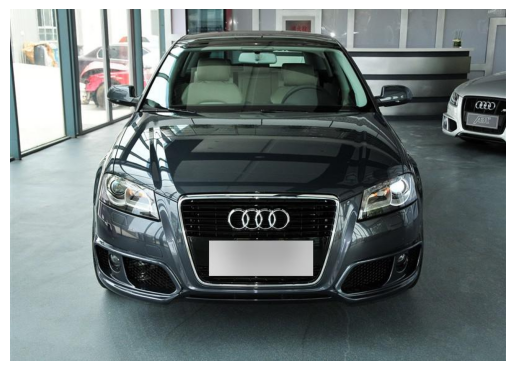

## check label

In [ ]:


# Load the .mat file
car_type_mat_path = os.path.join(DATA_DIR, 'misc', 'car_type.mat')
car_type_data = scipy.io.loadmat(car_type_mat_path)

# Check the keys in the loaded .mat file
print(car_type_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'types'])


In [76]:
id2label = {i+1:str(j[0]) for i,j in enumerate(car_type_data['types'][0])}

## check empty attributes

In [66]:
# Read the original attributes.txt
attributes_txt_path = os.path.join(DATA_DIR, 'misc', 'attributes.txt')
with open(attributes_txt_path, 'r') as f:
    lines = f.readlines()

# Filter out lines ending with '0' (after stripping whitespace)
filtered_lines = [line for line in lines if not line.strip().endswith('0')]

# Write the filtered lines to a new file
new_attributes_txt_path = os.path.join(DATA_DIR, 'misc', 'attributes_filtered.txt')
with open(new_attributes_txt_path, 'w') as f:
    f.writelines(filtered_lines)

In [71]:
from collections import Counter

# Walk through the image directory and count images per model_id
model_image_counts = Counter()
for make_folder in os.listdir(os.path.join(DATA_DIR, 'image')):
    make_path = os.path.join(DATA_DIR, 'image', make_folder)
    if not os.path.isdir(make_path):
        continue
    for model_folder in os.listdir(make_path):
        model_path = os.path.join(make_path, model_folder)
        if not os.path.isdir(model_path):
            continue
        # Recursively walk through all years and count images
        for year_folder in os.listdir(model_path):
            year_path = os.path.join(model_path, year_folder)
            if not os.path.isdir(year_path):
                continue
            image_files = [f for f in os.listdir(year_path) if f.lower().endswith('.jpg')]
            model_image_counts[int(model_folder)] += len(image_files)

# Convert to DataFrame for easier viewing
model_image_counts_df = pd.DataFrame(list(model_image_counts.items()), columns=['model_id', 'image_count'])
model_image_counts_df = model_image_counts_df.sort_values('image_count', ascending=False)
model_image_counts_df

,model_id,image_count
1043,196,303
121,1915,288
778,68,283
1352,127,272
101,1917,237
...,...,...
1290,1469,1
1488,693,1
1153,1338,1
51,1997,1


In [72]:
# Read the filtered attributes file into a DataFrame
attributes_df = pd.read_csv(new_attributes_txt_path, sep=' ')
attributes_df

,model_id,maximum_speed,displacement,door_number,seat_number,type
0,1,235,1.8,5,5,4
1,2,220,1.8,4,5,3
2,3,228,2.0,4,5,3
3,4,230,2.0,5,5,2
4,5,234,3.0,5,5,2
...,...,...,...,...,...,...
907,1984,150,2.2,4,5,8
908,1985,130,2.8,4,5,8
909,1986,150,2.4,5,5,2
910,1989,160,1.5,5,5,2


In [78]:
newdf = attributes_df.merge(model_image_counts_df, on='model_id', how='left')
newdf.groupby('type',as_index=False).agg({'image_count': 'sum'}).sort_values('image_count', ascending=False).replace({'type': id2label}).reset_index(drop=True)

,type,image_count
0,sedan,32274
1,SUV,21815
2,hatchback,16573
3,MPV,6149
4,minibus,4729
5,fastback,2473
6,hardtop convertible,2473
7,pickup,2134
8,estate,1215
9,convertible,1047


# idd dataset

In [35]:
id2label_idd = {
    "0": "traffic sign",
    "1": "motorcycle",
    "2": "car",
    "3": "rider",
    "4": "person",
    "5": "truck",
    "6": "autorickshaw",
    "7": "vehicle fallback",
    "8": "bus"
}
label2id_idd = {v: k for k, v in id2label_idd.items()}

## restructure the directory

In [ ]:
DATA_DIR = os.path.join('data/IDD_Detection')

#create target dir
OUT_DIR = os.path.join('data','IDD_Detection_COCO')
for i in ['images','annotations_xml']:
    for j in ['train','test','val']:
        os.makedirs(os.path.join(OUT_DIR,i,j),exist_ok=True)

In [ ]:
#copy img and label in cityscape format from original dir to target dir
for j in ['train','test','val']:
    print(f'Processing {j} set...')
    with open(os.path.join(DATA_DIR,j+'.txt'), 'r') as f:
        lines = f.readlines()
    for line in tqdm(lines):
        line = line.strip('\n')
        if not line: continue
        src_img_path = os.path.join(DATA_DIR, 'JPEGImages', line+'.jpg')
        dst_img_path = os.path.join(OUT_DIR, 'images', j, '-'.join(line.split('/'))+'.jpg')
        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)

        src_label_path = os.path.join(DATA_DIR, 'Annotations', line+'.xml')
        dst_label_path = os.path.join(OUT_DIR, 'annotations_xml', j, '-'.join(line.split('/'))+'.xml')

Processing train set...


100%|██████████| 31569/31569 [00:42<00:00, 751.07it/s] 


Processing test set...


100%|██████████| 4794/4794 [00:07<00:00, 668.39it/s]


Processing val set...


100%|██████████| 10225/10225 [00:14<00:00, 702.44it/s]


## convert to coco format

In [6]:
import json
from glob import glob

import xml.etree.ElementTree as ET

# Define paths
idd_ann_dir = os.path.join('.', 'data', 'IDD_Detection', 'Annotations')
idd_img_dir = os.path.join('.', 'data', 'IDD_Detection', 'JPEGImages')

In [50]:
# Helper: get all annotation files
xml_files = glob(os.path.join(idd_ann_dir,'frontFar','BLR-2018-03-22_17-39-26_2_frontFar', '*.xml'))
for i, xml_file in enumerate(xml_files):
    if i % 100 == 0:
        print(f"Processing {i}/{len(xml_files)}: {xml_file}")

    # Parse XML file
    if not os.path.exists(xml_file):
        print(f"File not found: {xml_file}")
        continue
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    folder = root.find('folder').text if root.find('folder') is not None else ''
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    anns = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        if name not in label2id_idd:
            continue
        category_id = label2id_idd[name]
        bndbox = obj.find('bndbox')
        try:
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
        except (AttributeError, ValueError, TypeError):
            continue
        w = xmax - xmin
        h = ymax - ymin
        if w <= 0 or h <= 0:
            continue
        anns.append({
            "category_id": category_id,
            "area": w * h,
            "bbox": [xmin, ymin, w, h]
        })

    if anns:
        categories = [ann['category_id'] for ann in anns]
        bboxes = [ann['bbox'] for ann in anns]
        areas = [ann['area'] for ann in anns]
        cppe5_annotations.append({
            "file_name": f"frontFar/{folder}/{filename}",
            "height": height,
            "width": width,
            "objects": {
                "category": categories,
                "bbox": bboxes,
                "area": areas
            }
        })

Processing 0/387: ./data/IDD_Detection/Annotations/frontFar/BLR-2018-03-22_17-39-26_2_frontFar/001404_r.xml
Processing 100/387: ./data/IDD_Detection/Annotations/frontFar/BLR-2018-03-22_17-39-26_2_frontFar/0007320.xml
Processing 200/387: ./data/IDD_Detection/Annotations/frontFar/BLR-2018-03-22_17-39-26_2_frontFar/0001980.xml
Processing 300/387: ./data/IDD_Detection/Annotations/frontFar/BLR-2018-03-22_17-39-26_2_frontFar/000450_r.xml


## verify

In [20]:
{
    "0": "traffic sign",
    "1": "motorcycle",
    "2": "car",
    "3": "rider",
    "4": "person",
    "5": "truck",
    "6": "autorickshaw",
    "7": "vehicle fallback",
    "8": "bus"
}.values()

dict_values(['traffic sign', 'motorcycle', 'car', 'rider', 'person', 'truck', 'autorickshaw', 'vehicle fallback', 'bus'])

In [3]:
from datasets import load_dataset

/Users/izzan/fun_projects/pusan/pusan_car_detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
ds = load_dataset("data/IDD_Detection_CPPE5",data_dir='data/IDD_Detection_CPPE5')

Generating train split: 31569 examples [00:02, 11495.77 examples/s]
Generating validation split: 10225 examples [00:00, 12072.94 examples/s]


In [2]:
int(720*(16)/9)

1280

In [34]:
ds.push_to_hub("IDD_Detection_CPPE5")

Uploading the dataset shards: 100%|██████████| 11/11 [10:19<00:00, 56.29s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/izzako/IDD_Detection_CPPE5/commit/886611b3ca4b0431add991170b90f6054f0f4536', commit_message='Upload dataset', commit_description='', oid='886611b3ca4b0431add991170b90f6054f0f4536', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/izzako/IDD_Detection_CPPE5', endpoint='https://huggingface.co', repo_type='dataset', repo_id='izzako/IDD_Detection_CPPE5'), pr_revision=None, pr_num=None)

In [43]:
data[0]['objects']['category']

[1, 3, 1, 3, 1, 3, 1, 3, 2, 1, 3]

In [7]:
import json
from collections import Counter

# Load the train.json file
with open('data/IDD_Detection_CPPE5/annotations/val.json', 'r') as f:
    data = json.load(f)

# Extract all category ids from annotations
category_ids = []
for image in data:
    category_ids+= image['objects']['category']

# Count statistics
category_counts = Counter(category_ids)
print("Category statistics (category_id: count):")
for cat_id, count in category_counts.items():
    print(f"{cat_id}: {count}")

Category statistics (category_id: count):
1: 25489
3: 24518
4: 18078
6: 7782
2: 24844
8: 4916
5: 7078
7: 6089
0: 4287


In [6]:
image['objects']['bbox']

[[231, 407, 47, 114],
 [305, 447, 100, 74],
 [451, 456, 72, 99],
 [755, 429, 147, 126],
 [1152, 331, 263, 140],
 [1834, 415, 83, 151]]

In [8]:
for image in data:
    # ensure bbox length is 4
    if any([len(i)>4 for i in image['objects']['bbox']]):
        print(f"Image {image['file_name']} has invalid bbox length.")
        continue